##**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from termcolor import colored
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

pd.options.mode.copy_on_write = True
sns.set_style('darkgrid')

# Defining a custom color palette with red, orange, and yellow tones
custom_palette = ['#FF5733', '#FFC300', '#FFD700', '#FFA07A', '#FF6347',
                  '#FF8C00', '#FF4500', '#FF7F50', '#FFA500', '#FFDAB9']

# Setting the custom color palette
sns.set_palette(custom_palette)

##**LOADING DATA**

In [25]:
data = pd.read_csv('data/winequality-red.csv', sep=';')
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

###***Source - https://archive.ics.uci.edu/dataset/186/wine+quality***

##**RENAMING COLUMNS**

In [26]:
data.rename(columns = {"fixed acidity": "fixed_acidity",
                       "volatile acidity": "volatile_acidity",
                       "citric acid": "citric_acid",
                       "residual sugar": "residual_sugar",
                       "chlorides": "chlorides",
                       "free sulfur dioxide": "free_sulfur_dioxide",
                       "total sulfur dioxide": "total_sulfur_dioxide"},
            inplace = True)

##**CHECKING SHAPE**

In [5]:
data.shape

(1599, 12)

##**NAMES OF ALL COLUMNS**

In [22]:
data.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

##**DATA INFORMATION**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


##**DESCRIPTIVE STATISTICS**

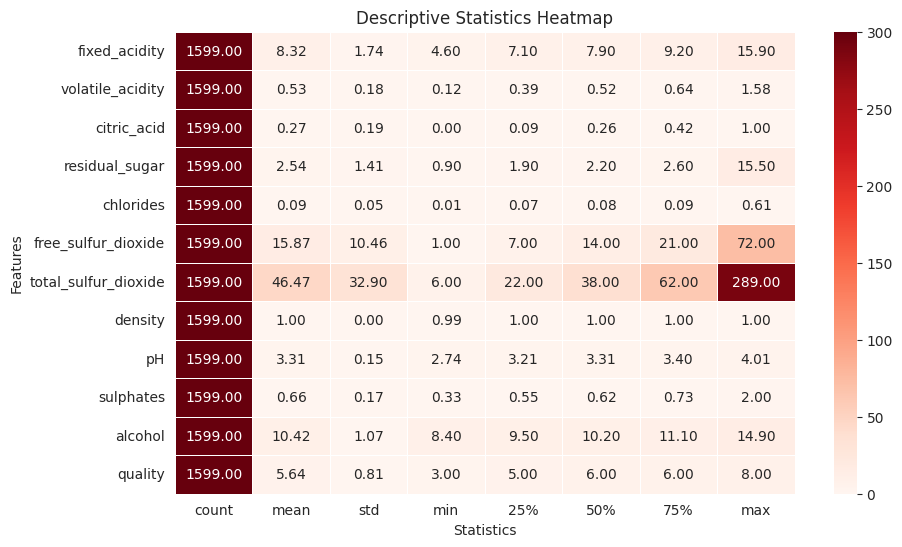

In [ ]:
# Calculate descriptive statistics and transpose the result
descriptive_stats = data.describe().T

# Create a heatmap-style plot with color gradients
plt.figure(figsize=(10, 6))
sns.heatmap(descriptive_stats, cmap='Reds', annot=True, fmt='.2f', linewidths=0.5, vmin=0, vmax=300)

plt.xlabel('Statistics')
plt.ylabel('Features')
plt.title('Descriptive Statistics Heatmap')

plt.show()

##**MISSING VALUES**

In [ ]:
print(data.isna().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


###**No missing values**

##**PERCENTAGE MISSING VALUES IN EACH COLUMN**

In [ ]:
percent = data.isnull().sum()*100/len(data)
print(percent)

fixed_acidity           0.0
volatile_acidity        0.0
citric_acid             0.0
residual_sugar          0.0
chlorides               0.0
free_sulfur_dioxide     0.0
total_sulfur_dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64


#**EXPLORATORY DATA ANALYSIS**

In [ ]:
columns = list(data.columns)

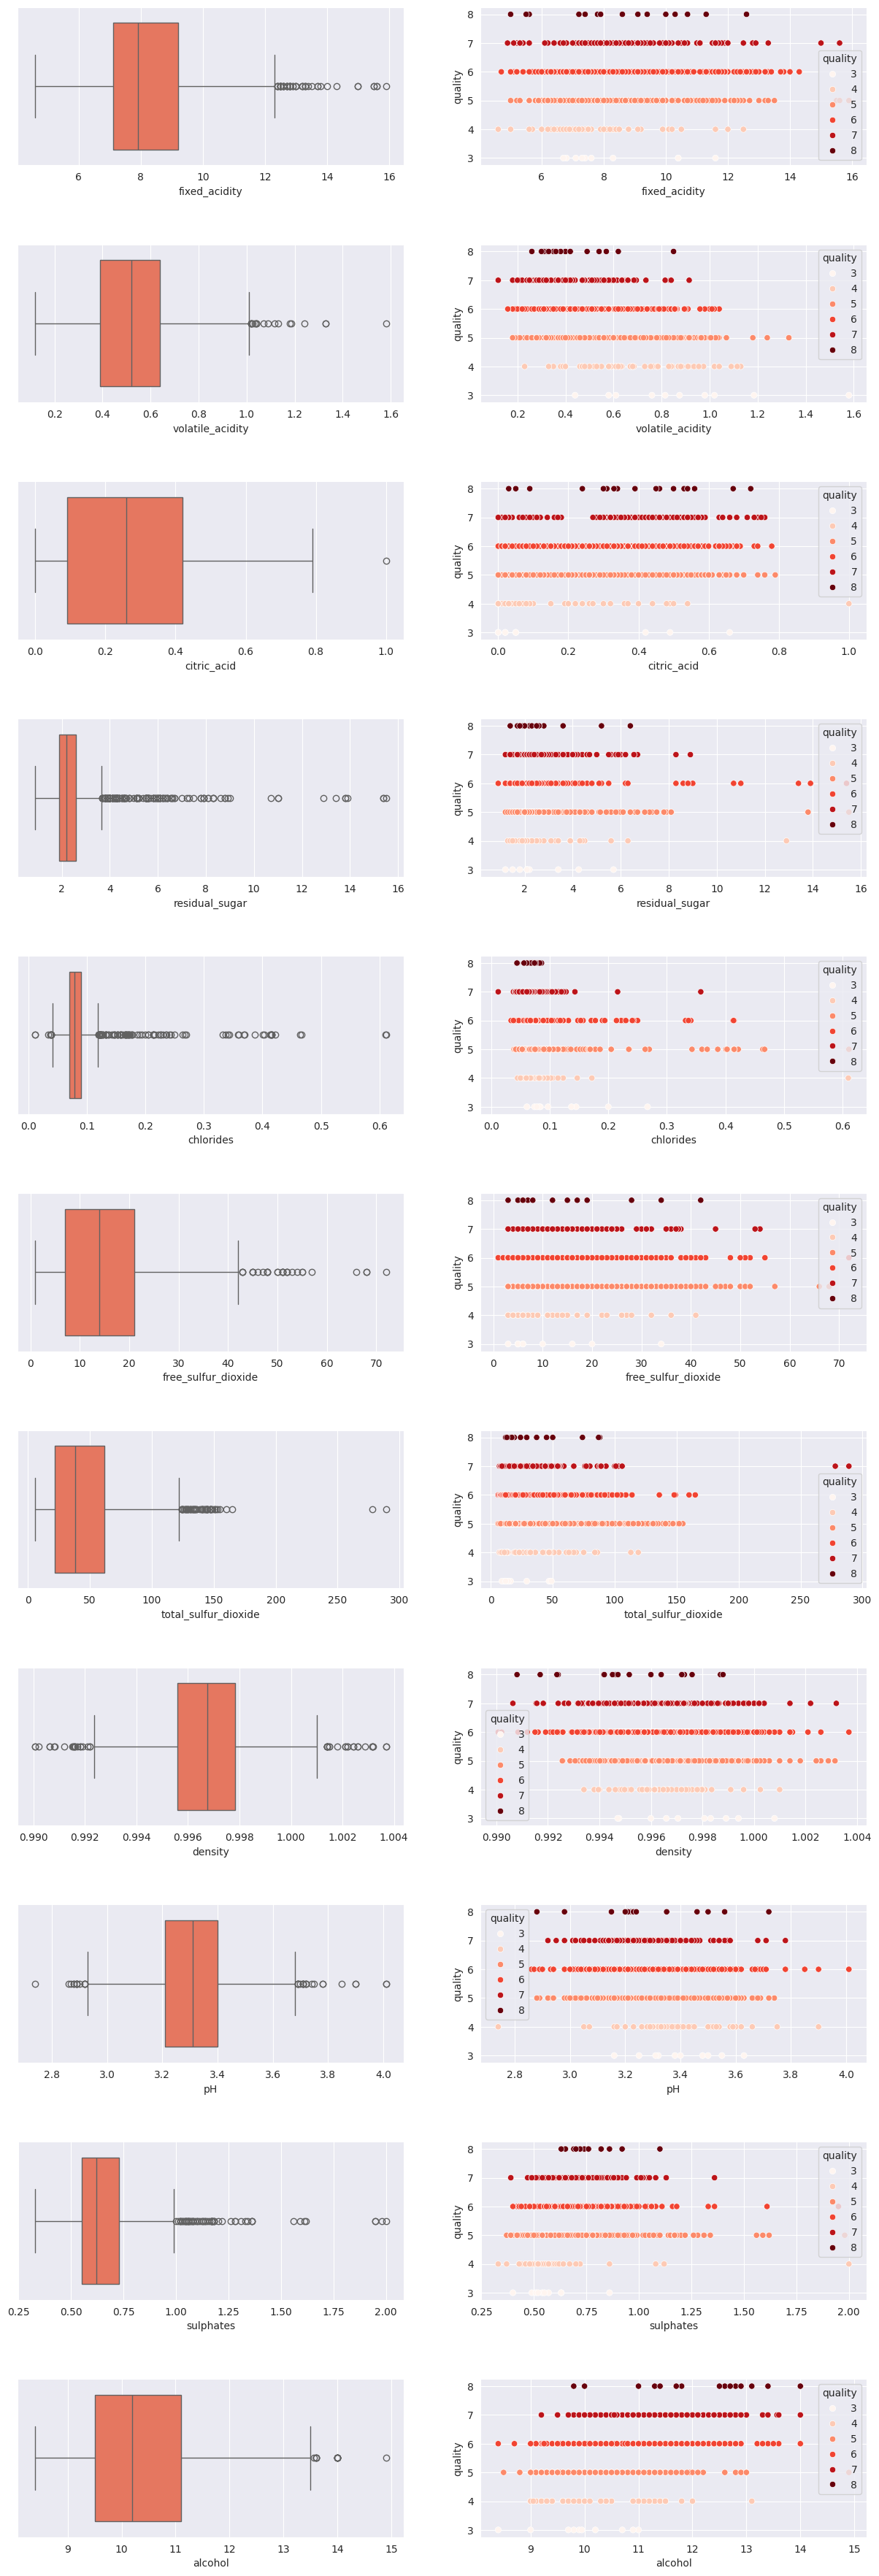

In [ ]:
fig, ax = plt.subplots(11, 2, figsize=(15, 45))
plt.subplots_adjust(hspace=0.5)
for i in range(11):
    # AX 1
    sns.boxplot(x=columns[i], data=data, ax=ax[i, 0], palette='Reds')
    # Ax 2
    sns.scatterplot(x=columns[i], y='quality', data=data, hue='quality', ax=ax[i, 1], palette='Reds')

##**HANDLING OUTLIERS**

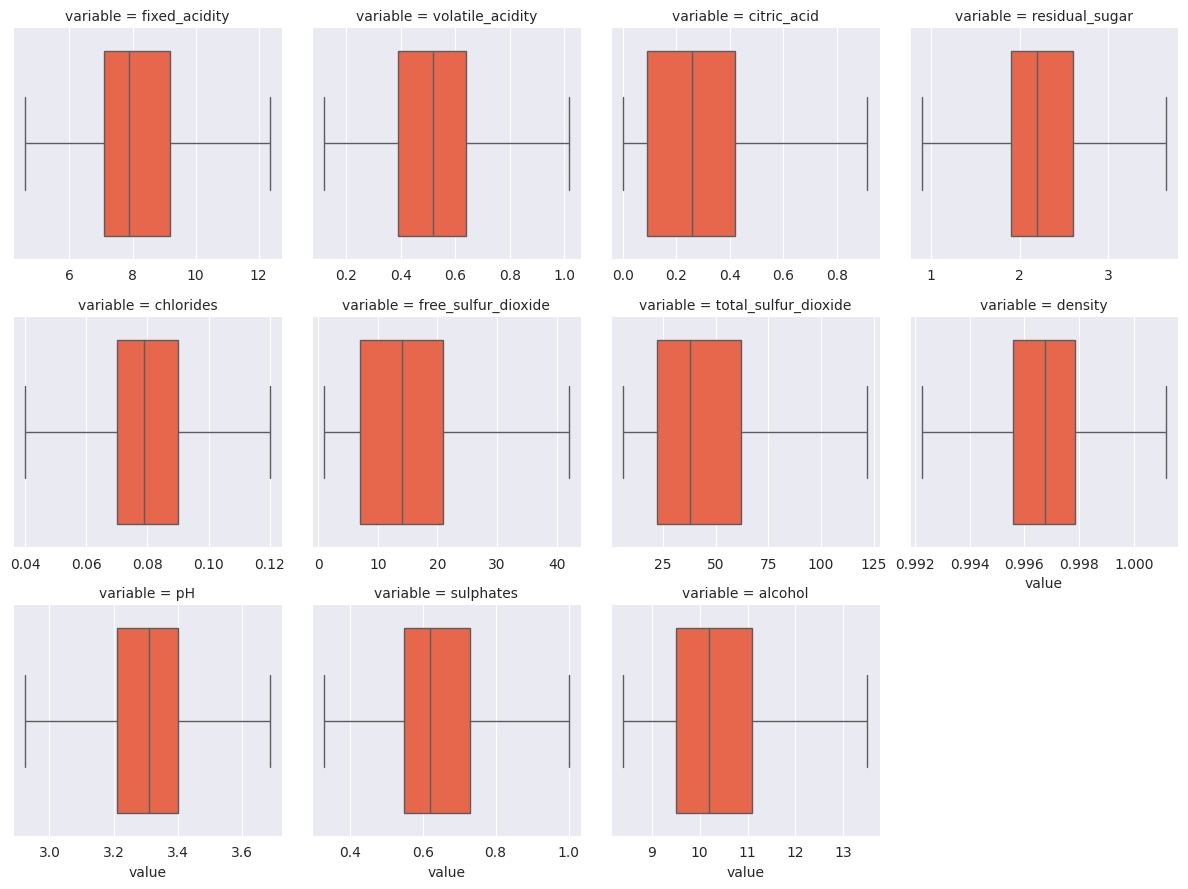

In [27]:
# Select numerical columns excluding 'quality'
numerical_cols = data.select_dtypes(include=['int', 'float']).drop(columns='quality', errors='ignore')

# Define a function to handle outliers using the IQR method
def handle_outliers_iqr(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    return data

# Iterate over numerical columns and handle outliers
for col in numerical_cols.columns:
    data = handle_outliers_iqr(data, col)

# Melt the dataframe to long format
df_melted = pd.melt(data[numerical_cols.columns])

# Create FacetGrid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=4, sharex=False)
g = g.map(sns.boxplot, "value")

plt.show()

##**HISTOGRAMS**

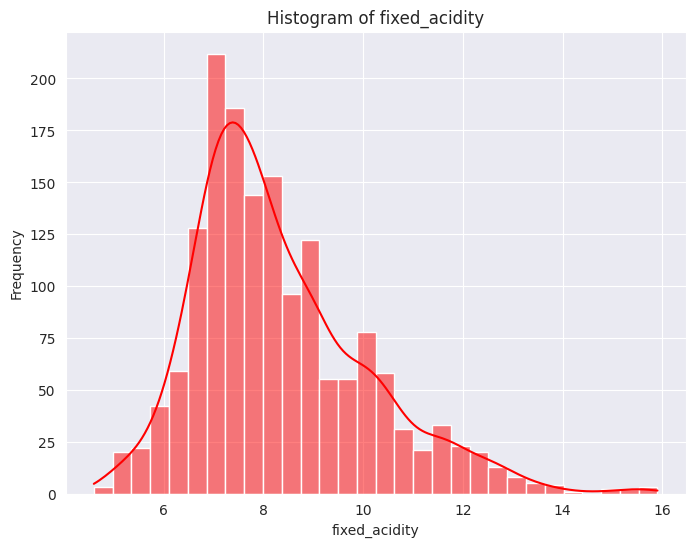

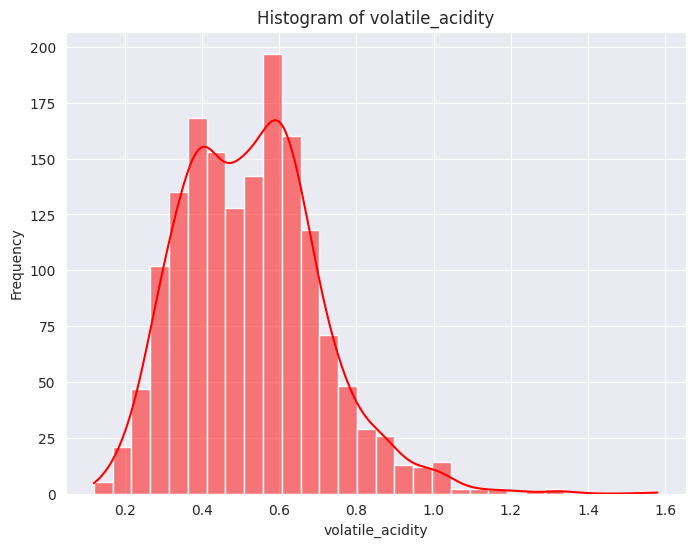

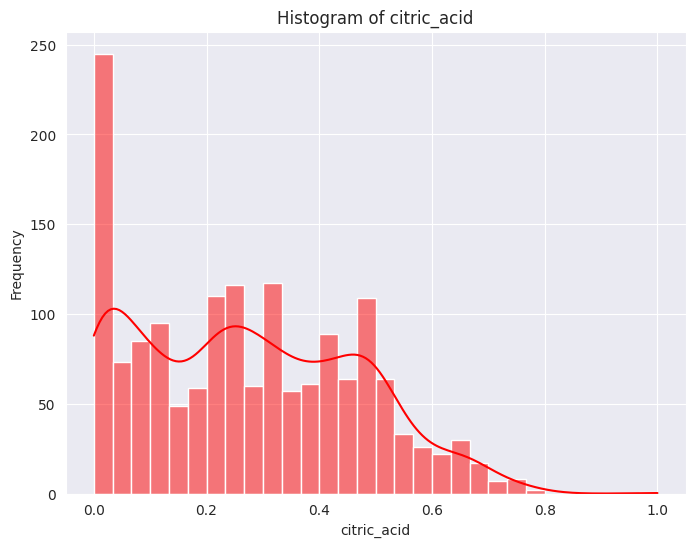

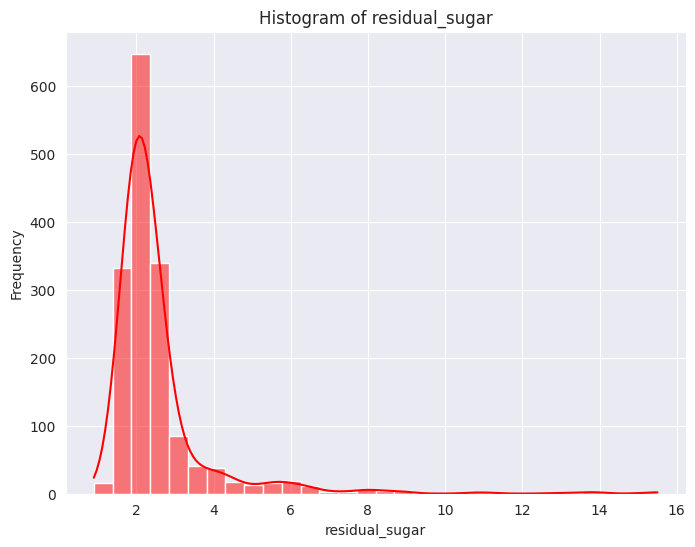

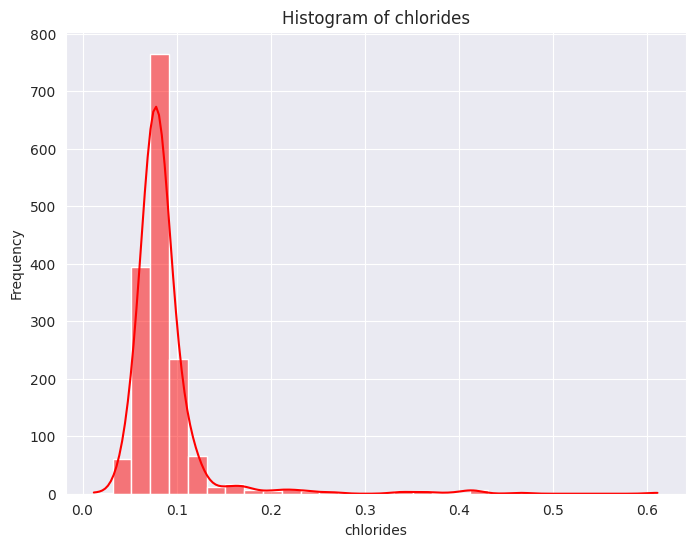

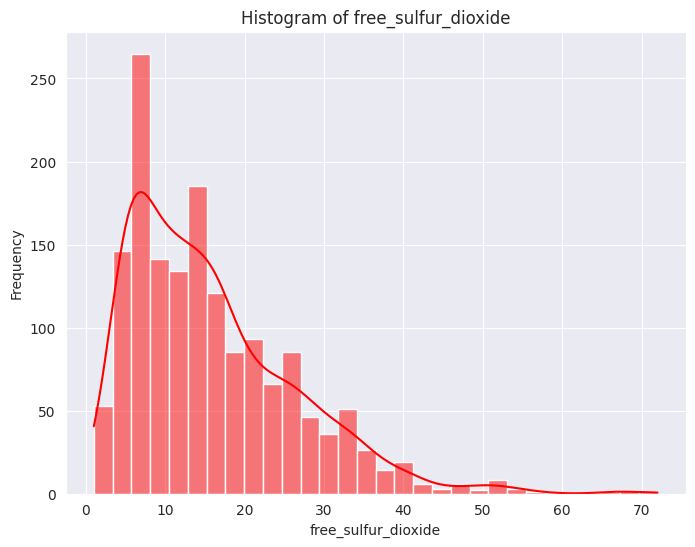

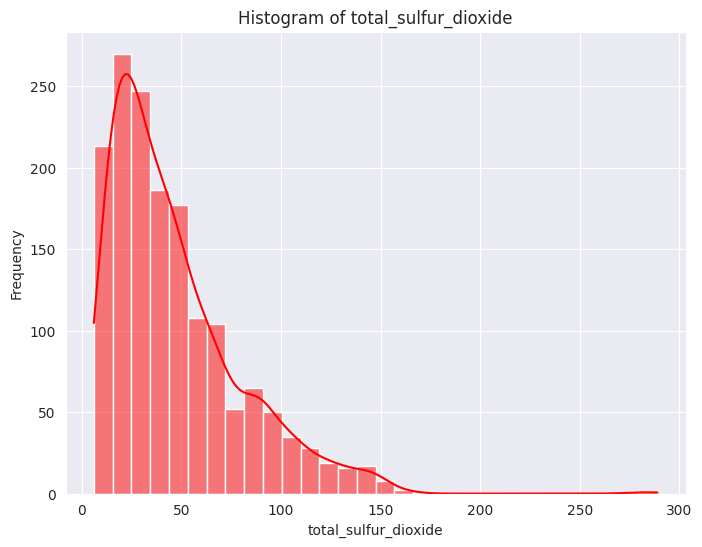

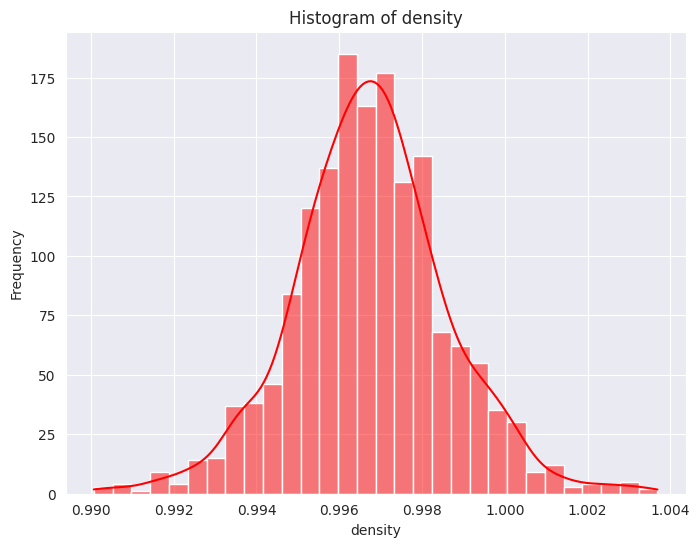

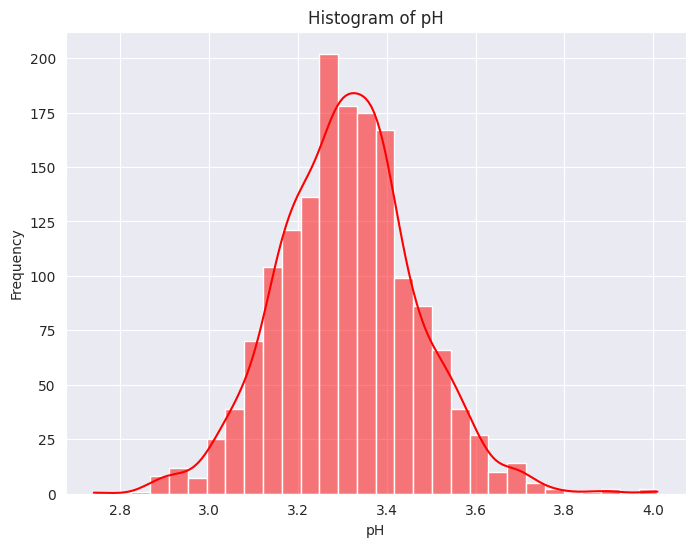

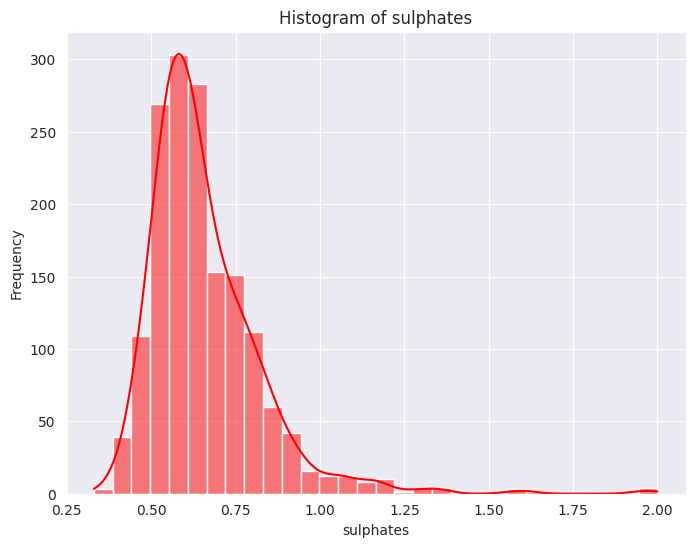

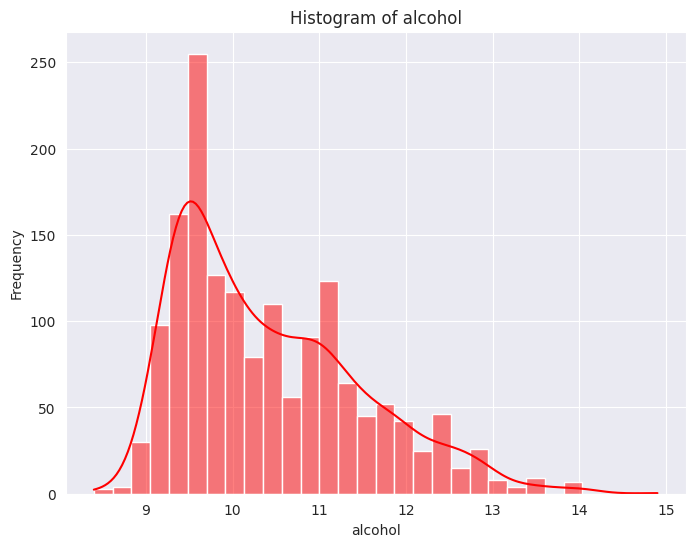

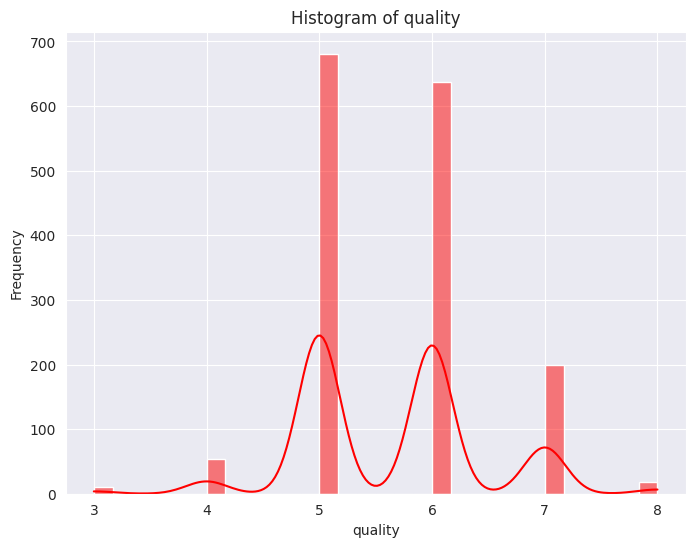

In [ ]:
def create_histograms(df, column_names):
    for col in column_names:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], bins=30, kde=True, color='red')
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

column_names = list(data.columns)
create_histograms(data, column_names)

##**CORRELATION MATRIX**

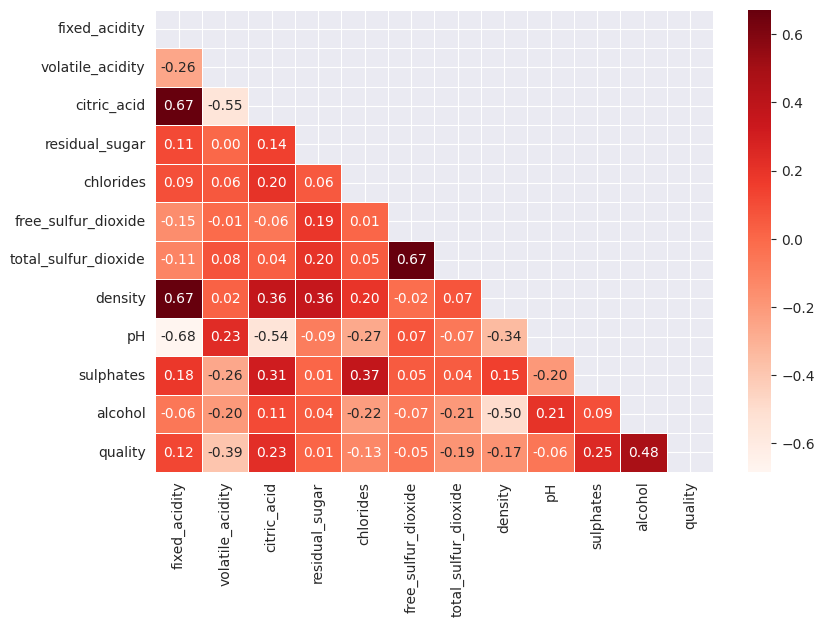

In [ ]:
corr = data.corr()
# cmap = sns.diverging_palette(-1, 1, s=100, l=50, n=15, center="dark", as_cmap=True)
plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.5, cmap='Reds', mask=np.triu(corr))
plt.show()

##**PAIRPLOT**

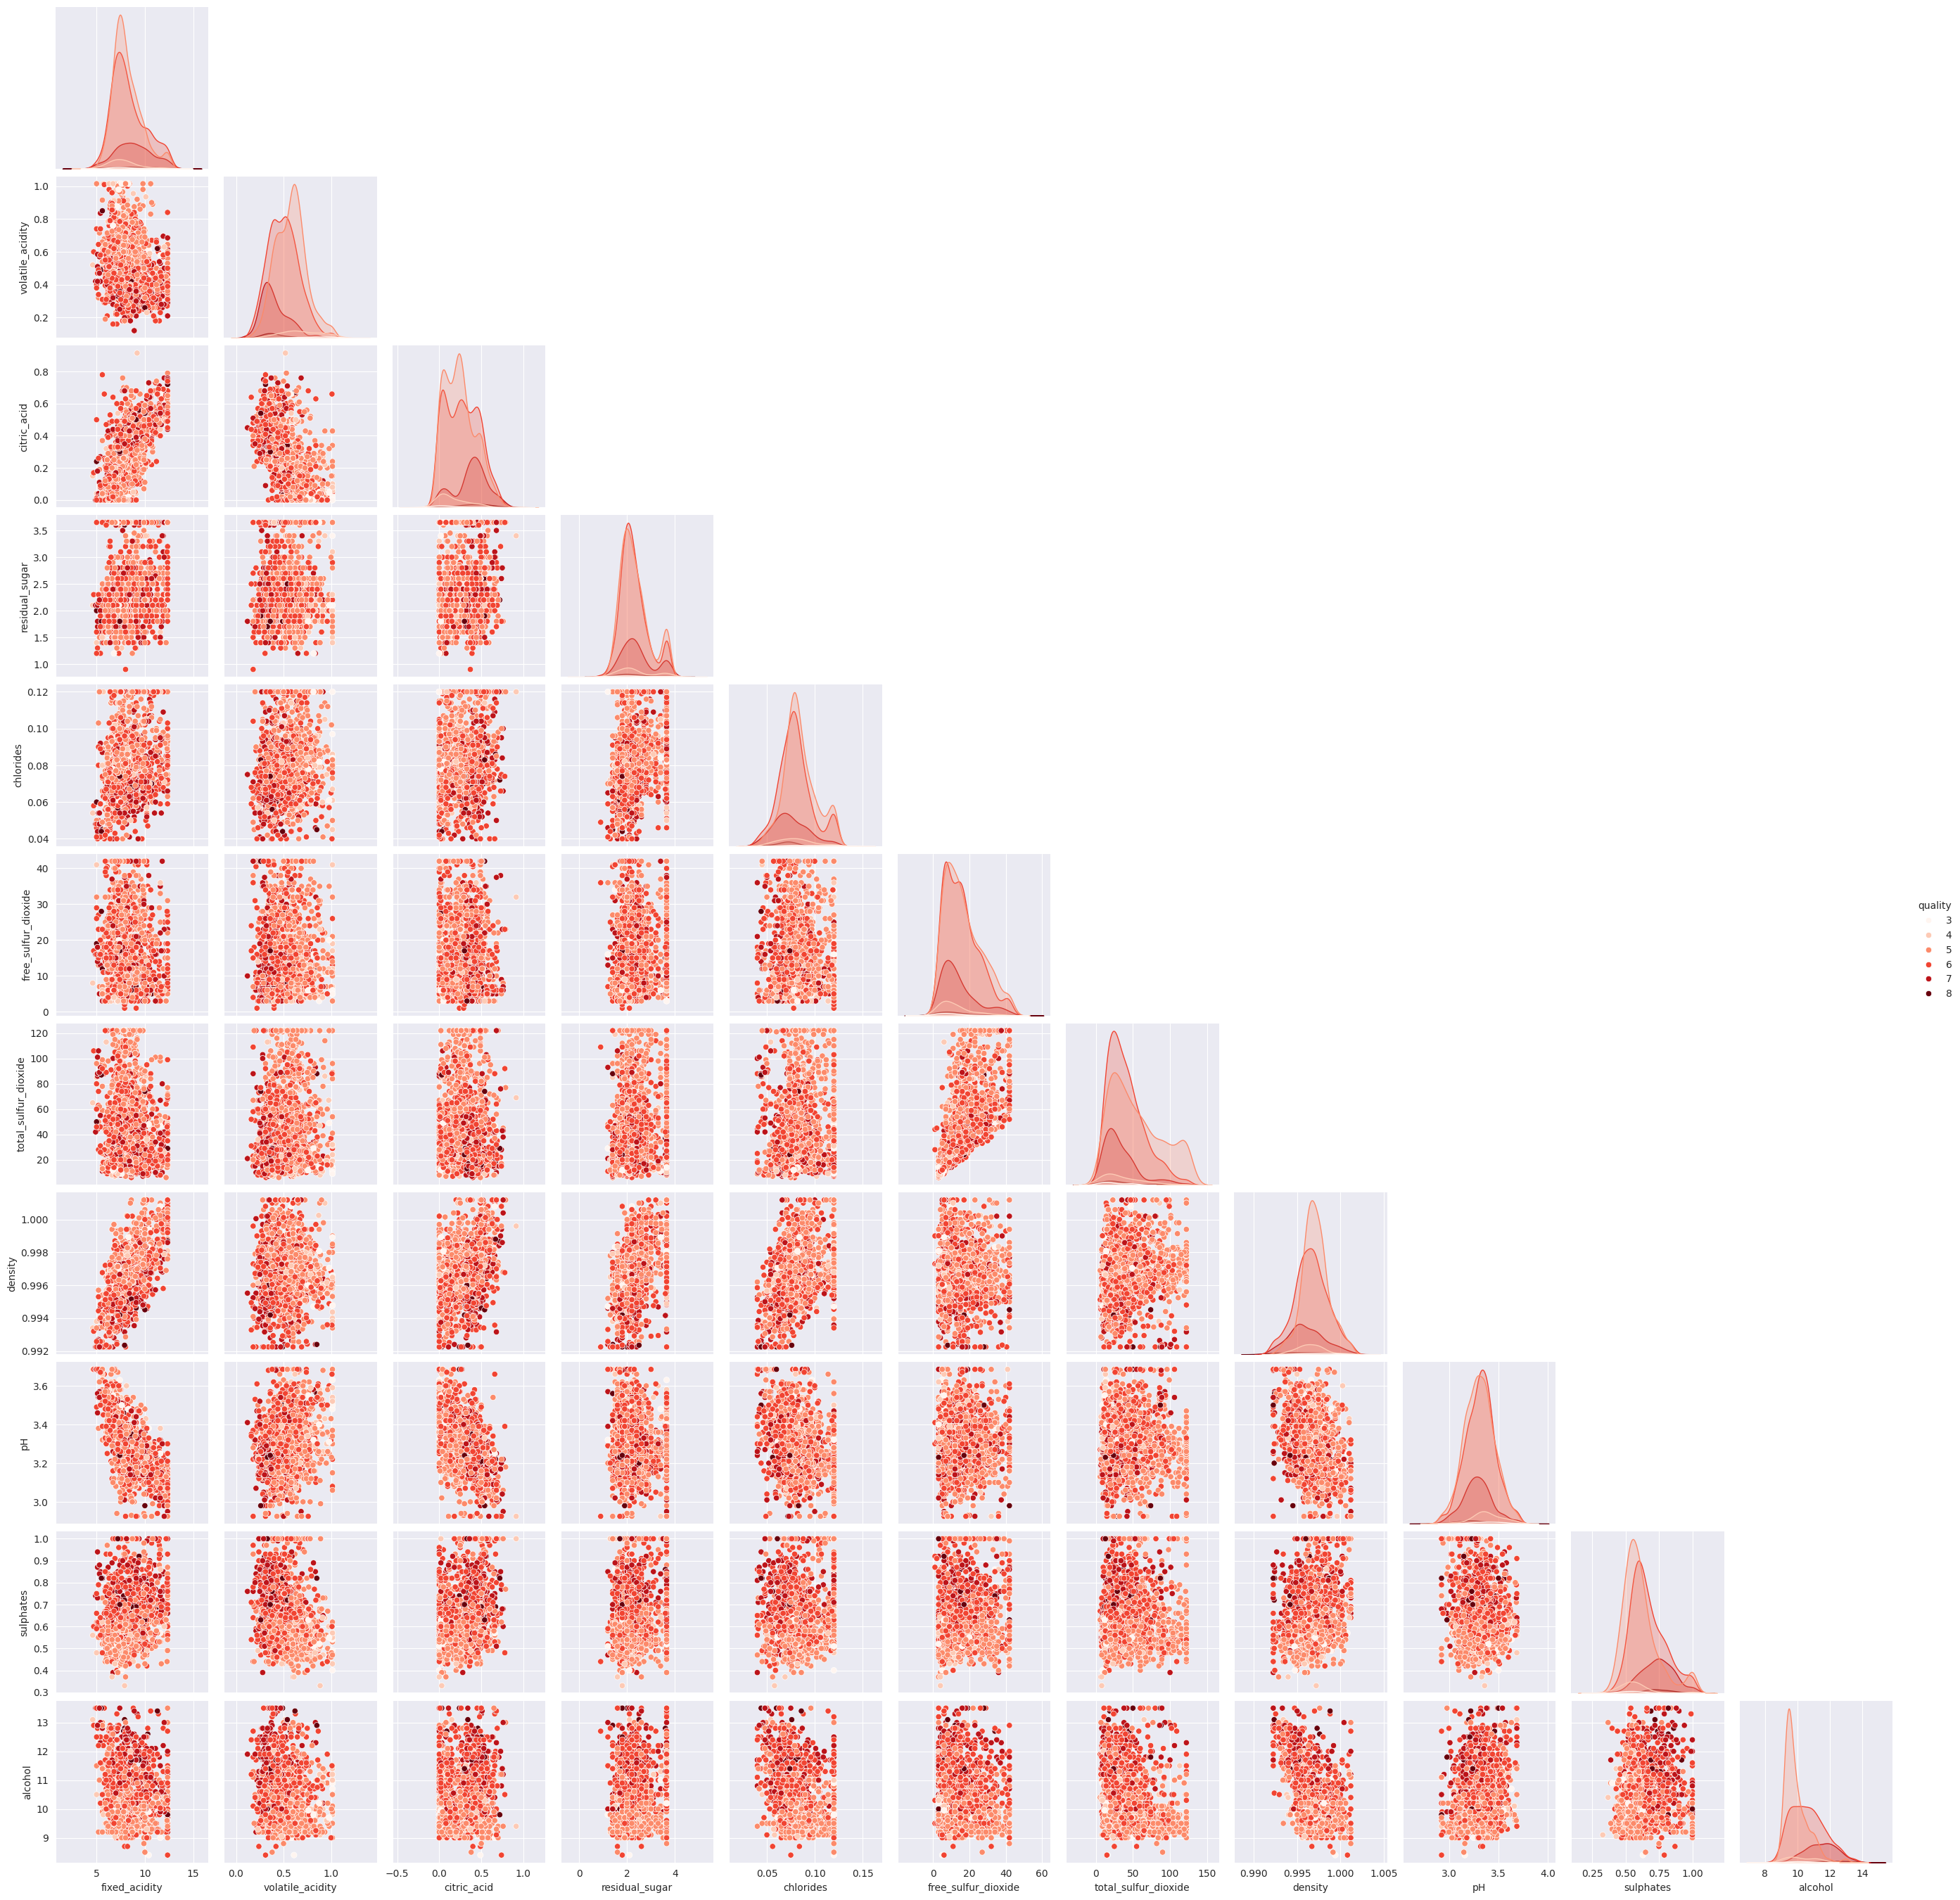

In [ ]:
sns.pairplot(data, hue='quality', corner=True, palette='Reds')

###**Best Correlations are between :**
1. citric_acid & flex_acidity ---> 0.68
2. density & flex_acidity ---> 0.67
3. total_sulfor_dioxide & free_sulfor_dioxide ---> 0.69

##**UNIQUE QUALITY CLASSES**

In [ ]:
data.quality.unique()

array([5, 6, 7, 4, 8, 3])

##**DISTRIBUTION OF WINE QUALITY CLASSES**

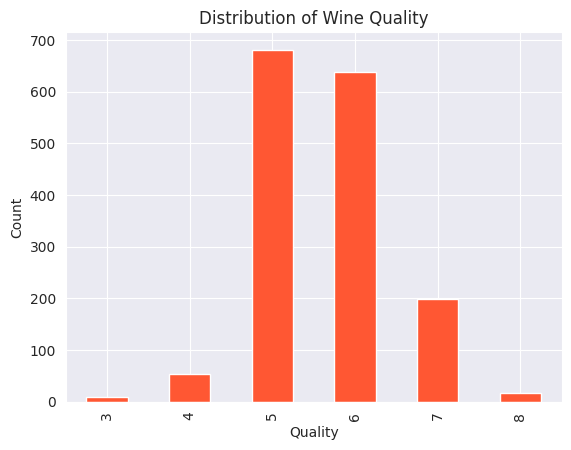

In [ ]:
data['quality'].value_counts().sort_index().plot(kind='bar', color='#FF5733')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality')
plt.show()

##**CLASS DISTRIBUTION PERCENTAGE**

In [ ]:
# Calculate the percentage of each class
class_distribution = data['quality'].value_counts(normalize=True) * 100

# Print the percentage of each class
for quality, percentage in class_distribution.items():
    print(f"Quality {quality}: {percentage:.2f}%")

Quality 5: 42.59%
Quality 6: 39.90%
Quality 7: 12.45%
Quality 4: 3.31%
Quality 8: 1.13%
Quality 3: 0.63%


**The distribution of wine quality classes reveals that Quality 5 is the most common, comprising 42.59% of the dataset, while Quality 3 is the least common at 0.63%. This imbalance suggests that the dataset is skewed towards certain quality levels. To address this imbalance, techniques such as SMOTE (Synthetic Minority Over-sampling Technique) can be employed to ensure a more balanced representation of each class, which can improve the performance of machine learning models.**

##**HANDLING CLASS IMBALANCE WITH SMOTE**

In [28]:
# Assuming 'data' is your DataFrame and 'quality' is the column with target classes
X = data.drop('quality', axis=1)
y = data['quality']

# Apply SMOTE
smote = SMOTE()
X_smote, y_smote_original = smote.fit_resample(X, y)

# Concatenate X_smote and y_smote_original along columns axis (axis=1)
data = pd.concat([X_smote, pd.Series(y_smote_original, name='quality')], axis=1)

##**CHECKING SHAPE**

In [5]:
data.shape

(4086, 12)

##**DISTRIBUTION OF WINE QUALITY CLASSES**

Quality 3: 16.67%
Quality 4: 16.67%
Quality 5: 16.67%
Quality 6: 16.67%
Quality 7: 16.67%
Quality 8: 16.67%


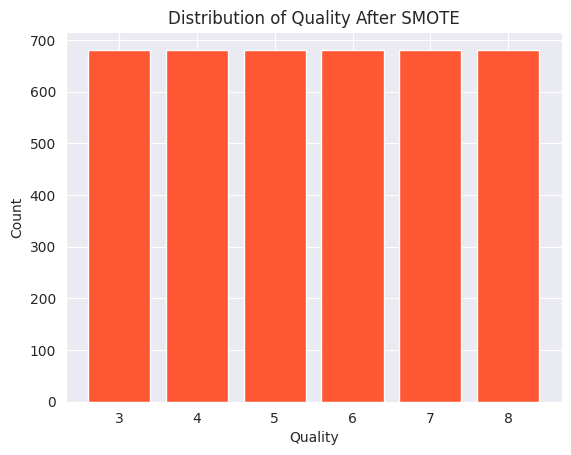

In [6]:
# Distribution of all the columns in the balanced Dataset
unique, counts = np.unique(data['quality'], return_counts=True)

# Print percentages
total_samples = len(data)
for u, c in zip(unique, counts):
    print(f'Quality {u}: {c/total_samples*100:.2f}%')

# Plot distribution
plt.bar(unique, counts)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Quality After SMOTE')
plt.show()

##**CREATE FEATURES AND TARGET**

In [29]:
X = data.drop('quality', axis=1)
y = data['quality']

##**STANDARDIZATION & DESCRIPTIVE STATISTICS AFTER STANDARDIZATION**

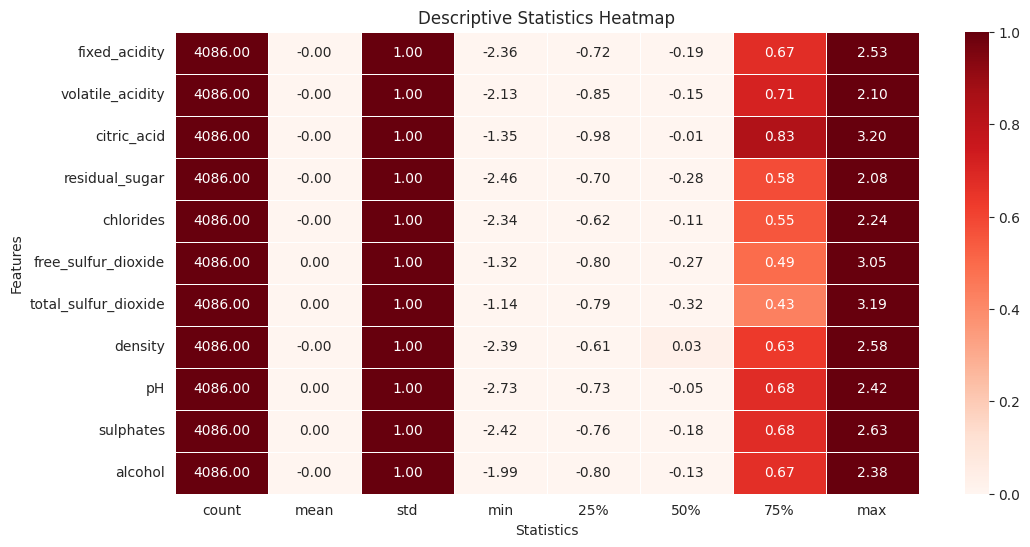

In [30]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Descriptive Statistics and Heatmap (Optional)
descriptive_stats = X.describe().T

plt.figure(figsize=(12, 6))
sns.heatmap(descriptive_stats, cmap='Reds', annot=True, fmt='.2f', linewidths=0.5, vmin=0, vmax=1)
plt.xlabel('Statistics')
plt.ylabel('Features')
plt.title('Descriptive Statistics Heatmap')
plt.show()

##**TEST-TRAIN SPLIT**

In [31]:
# Splite Dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##**DEFINE AND INITIALISE THE CLASSIFIERS**

In [32]:
# Random Forest parameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# KNN parameters
knn_params = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance']
}

# Decision Tree parameters
dt_params = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize classifiers
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier(random_state=42)

##**GRID SEARCH WITH CROSS VALIDATION**

In [33]:
# Initialize GridSearchCV
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy')
dt_grid = GridSearchCV(dt_clf, dt_params, cv=5, scoring='accuracy')

# Fit GridSearchCV
rf_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

##**EVALUATE THE BEST MODEL**

In [34]:
print("Best Random Forest parameters:", rf_grid.best_params_)
print("Best Random Forest score:", rf_grid.best_score_)

print("Best KNN parameters:", knn_grid.best_params_)
print("Best KNN score:", knn_grid.best_score_)

print("Best Decision Tree parameters:", dt_grid.best_params_)
print("Best Decision Tree score:", dt_grid.best_score_)

Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest score: 0.8416083916083915
Best KNN parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best KNN score: 0.8174825174825175
Best Decision Tree parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best Decision Tree score: 0.7583916083916084


##**MAKE PREDICTIONS ON TEST SET**

In [35]:
# Predict using the best models
y_pred_rf = rf_grid.predict(X_test)
y_pred_knn = knn_grid.predict(X_test)
y_pred_dt = dt_grid.predict(X_test)

In [36]:
# Calculate test accuracies
rf_test_acc = metrics.accuracy_score(y_test, y_pred_rf)
knn_test_acc = metrics.accuracy_score(y_test, y_pred_knn)
dt_test_acc = metrics.accuracy_score(y_test, y_pred_dt)

# Print the training and test accuracies
print(f"Random Forest: Test Accuracy: {rf_test_acc:.3f}")
print(f"KNN: Test Accuracy: {knn_test_acc:.3f}")
print(f"Decision Tree: Test Accuracy: {dt_test_acc:.3f}")

Random Forest: Test Accuracy: 0.837
KNN: Test Accuracy: 0.829
Decision Tree: Test Accuracy: 0.768


##**PLOTTING FUNCTION**

In [37]:
def plot_evaluation_results(y_test, y_pred):
    """Plots a confusion matrix and a classification report."""

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[3, 4, 5, 6, 7, 8])
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds", ax=ax[0],
                xticklabels=[3, 4, 5, 6, 7, 8],
                yticklabels=[3, 4, 5, 6, 7, 8])
    ax[0].set_xlabel('Predicted Labels', fontsize=14)
    ax[0].set_ylabel('True Labels', fontsize=14)
    ax[0].set_title('Confusion Matrix', fontsize=18)

    # Classification Report
    cr = metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)
    cr_df = pd.DataFrame(cr).T
    cr_df = cr_df.drop(columns=['support'])  # Optionally drop 'support' column
    sns.heatmap(cr_df, annot=True, cmap='Reds', linecolor='white',
                linewidths=0.5, ax=ax[1], fmt='.3f')
    ax[1].xaxis.tick_top()
    ax[1].set_title('Classification Report', fontsize=18)
    ax[1].set_xlabel('Metrics', fontsize=14)

    plt.tight_layout()
    plt.show()

##**PLOT EVALUATION RESULTS**

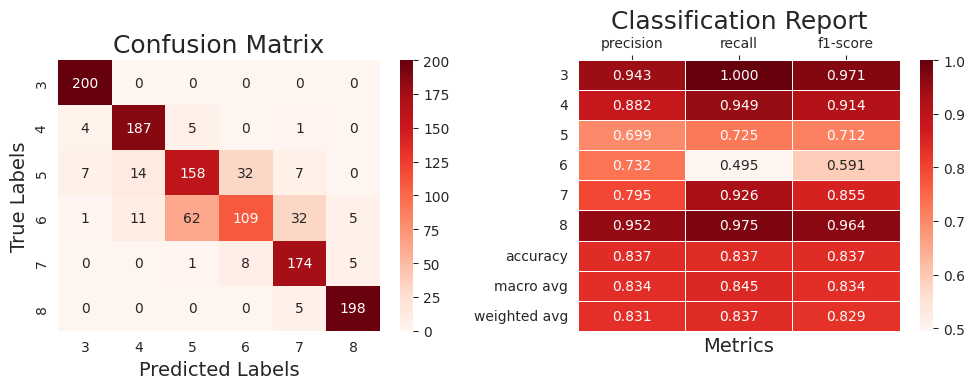

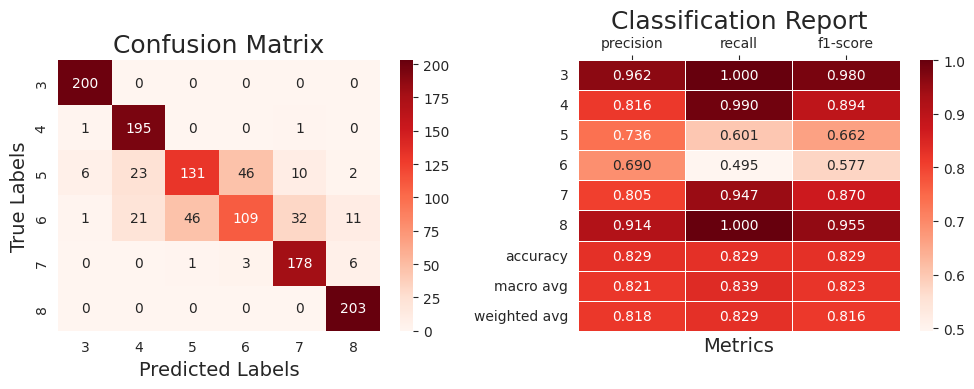

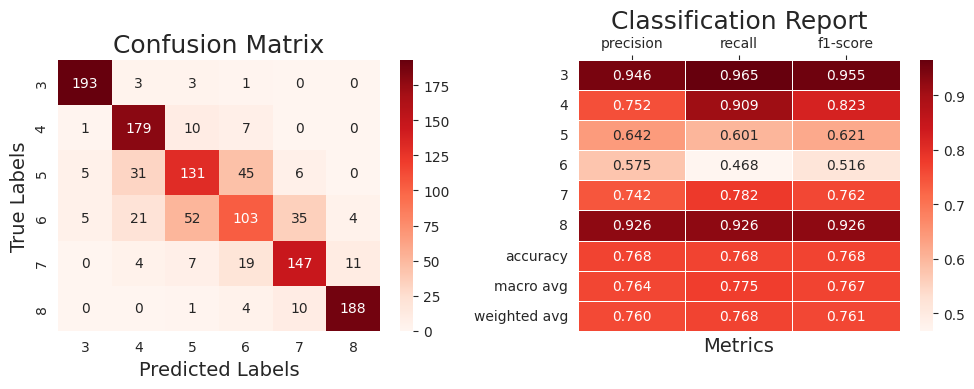

In [38]:
# Random Forest Evaluation
plot_evaluation_results(y_test, y_pred_rf)

# KNN Evaluation
plot_evaluation_results(y_test, y_pred_knn)

# Decision Tree Evaluation
plot_evaluation_results(y_test, y_pred_dt)

##**ONE HOT ENCODING**

In [39]:
# One-hot encode the target labels (wine quality 3 to 8)
y_one_hot = pd.get_dummies(y).values

##**TRAIN TEST SPLIT FOR ANN**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

##**ANN**

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, Callback
import matplotlib.pyplot as plt

In [42]:
# Define the Early stopping callback
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.85:
            print(f"\nReached 85% validation accuracy, stopping training at epoch {epoch+1}")
            self.model.save("best_model.h5")
            self.model.stop_training = True

# Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.1))
model.add(Dense(256, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.1))
model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.3))
model.add(Dense(1024, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##**TRAIN THE ANN**

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.3847 - loss: 2.5332 - val_accuracy: 0.6414 - val_loss: 1.6721
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5920 - loss: 1.5980 - val_accuracy: 0.6531 - val_loss: 1.4222
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6766 - loss: 1.3040 - val_accuracy: 0.6787 - val_loss: 1.2264
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7273 - loss: 1.1364 - val_accuracy: 0.7276 - val_loss: 1.1228
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7590 - loss: 0.9976 - val_accuracy: 0.7264 - val_loss: 1.0478
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7684 - loss: 0.9208 - val_accuracy: 0.7637 - val_loss: 0.9540
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7991 - loss: 0.8551 - val_accuracy: 0.7509 - val_loss: 0.9076
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7661 - loss: 0.8874 - val_ac


Reached 85% validation accuracy, stopping training at epoch 81
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9664 - loss: 0.3269 - val_accuracy: 0.8545 - val_loss: 0.8019
ANN Training Accuracy: 0.961
ANN Validation Accuracy: 0.854
ANN Test Accuracy: 0.819
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


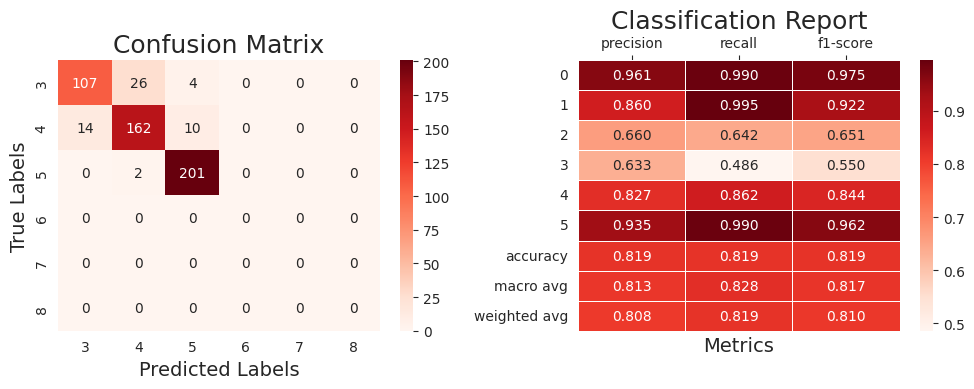

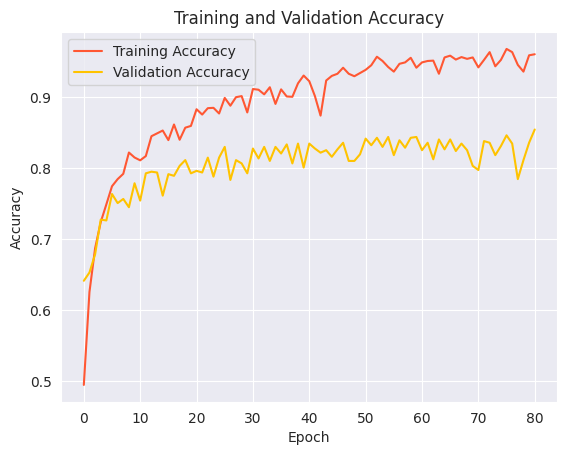

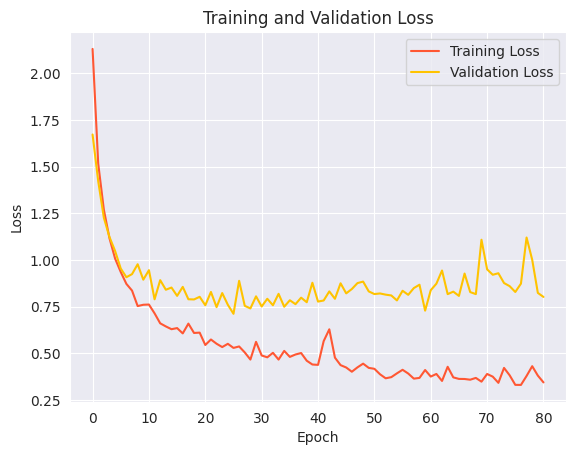

In [43]:
# Train the model
custom_early_stopping = CustomEarlyStopping()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.3, callbacks=[custom_early_stopping])

# Evaluate the model on training, validation, and test data
ann_train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
ann_val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy
ann_test_loss, ann_test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print the accuracies
print(f"ANN Training Accuracy: {ann_train_acc:.3f}")
print(f"ANN Validation Accuracy: {ann_val_acc:.3f}")
print(f"ANN Test Accuracy: {ann_test_acc:.3f}")

# Predict the classes on the test set
y_pred_ann = model.predict(X_test)
y_pred_ann_classes = y_pred_ann.argmax(axis=1)

# Convert y_test from one-hot to class labels for evaluation (if needed)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate and visualize the ANN results using your existing plot_evaluation_results function
plot_evaluation_results(y_test_labels, y_pred_ann_classes)

# Plot training history - Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot training history - Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##**COMPARISON OF RESULTS**

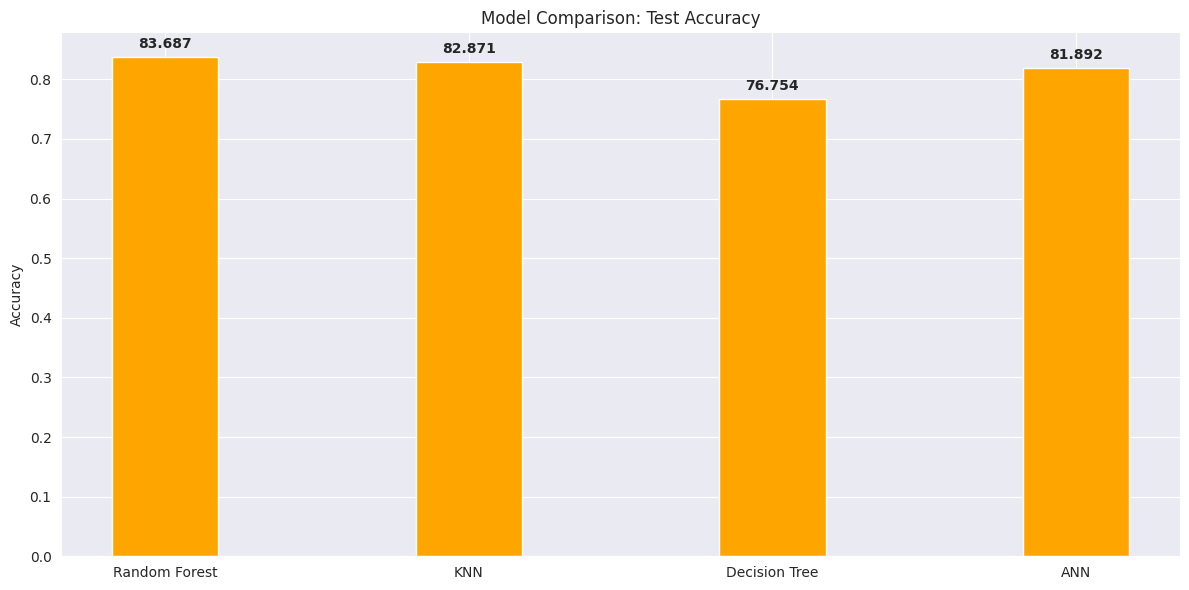

In [45]:
# Comparison plot
models = ['Random Forest', 'KNN', 'Decision Tree', 'ANN']
test_accuracies = [rf_test_acc, knn_test_acc, dt_test_acc, ann_test_acc]

bar_width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))

# Only plotting test accuracies
ax.bar(np.arange(len(models)), test_accuracies, bar_width, label='Test Accuracy', color='orange')

for i, acc in enumerate(test_accuracies):
    ax.text(i, acc + 0.01, f'{acc*100:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Test Accuracy')
#ax.legend()
plt.tight_layout()
plt.show()

##**CONCLUSION**

The **Random Forest model demonstrates the best performance** on the test set, achieving the highest accuracy of 83.687%. This indicates that Random Forest is best able to generalize to unseen data among the four models.

**Analysis:**

* **Random Forest:**  Its ensemble nature (combining multiple decision trees) and randomness introduced during training (bagging and random subspace) generally makes it more robust to overfitting and capable of capturing complex data patterns.
* **KNN:** Performs well, achieving a test accuracy close to the Random Forest. It's a simpler model but might be sensitive to the choice of 'k' (number of neighbors) and the distance metric used.
* **Decision Tree:** The lowest test accuracy suggests a potential for overfitting, as decision trees can create very complex decision boundaries if not properly pruned or regularized.
* **ANN:**  While the ANN's performance is good, it doesn't surpass the Random Forest in this particular scenario. There is a big gap between training (**96.1%**) and testing accuracy, suggesting some level of overfitting. Further hyperparameter tuning or data augmentation might be necessary to improve the ANN's generalization capabilities
